# 3D Overthrust data - POCS with completely irregular sampling

## Author: M.Ravasi

This notebook applies seismic interpolation to a 3D shot gather of the SEG/EAGE Overthrust 3D dataset. The data is randomly subsampled along both the x- the y-axes.

The famous POCS method (which we show to be a special instance of HQS) will be applied to the data and compared to two other popular algorithm in convex optimazion, namely L-ADMM and PD.

The notebook is organized as follows:

- data loading
- direct arrival mask creation
- non-stationary data shifting (alternatively one could use NMO correction)
- FK mask creation
- interpolation with various algorithms

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as sp_io
import pylops

try:
    import cupy as cp
except:
    print('Cupy not available...')

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import FISTA
from pylops.signalprocessing.patch3d   import patch3d_design

from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from pypocs.visual import explode_volume
from pypocs.interpolation import pocs_interpolate, admm_interpolate, hqs_interpolate, pd_interpolate
from pypocs.sampling import *
from pypocs.metric import *

## Parameters

In [2]:
# Global parameters
perc_subsampling = 0.2 # percentage of subsampling (if decimal, random subsample; if integer, regular subsampling)
verb = False # verbosity during reconstruction
skipdone = False # skip experiment if the result is already available in the experiments folder

# Windows for patching
nwin = (32, 32, 32) # size of the window
nover = (8, 8, 6) # overlap between windows
ixpatch, iypatch, itpatch = 1, 3, 2 # indices of the patch to visualize for QC

# Iterative solution
niter = 80
jsrnsave = 4

# Experiments (each list should have the same number of elements and this identifies the total number of experiments performed in this notebook)
affines     = [True,             True,             True]
identityops = [True,             False,             False]
norms =       [L0,               L0,               L0]
threshs =     [None,             [.05],             [.05]]
fkmasks =     [False,            False,            False]
algs =        [hqs_interpolate,  admm_interpolate,  pd_interpolate]

## Loading data

In [3]:
# Source
isrc = 3338*4 # selected source
print('Source:', isrc)

# Model size
ny, nx, nz = 200, 330, 155

# Data size
nt, nrxorig, nryorig = 1126, 177, 90
nrx, nry = 176, 80
dt = 0.004
dx = 20

data = np.fromfile('../../data/Overthrust//p_full%d.rsf@' % isrc, dtype='float32')
data = data.reshape(nt+75, nrxorig * nryorig)[75:]
data = data.reshape(nt, nryorig, nrxorig).transpose(2,1,0) # y,x,t
data = data[:nrx, :nry, :500]/np.max(np.abs(data[:nrx, :nry, :500]))

ns, nr, nt = data.shape
print(data.shape)

Source: 13352
(176, 80, 500)


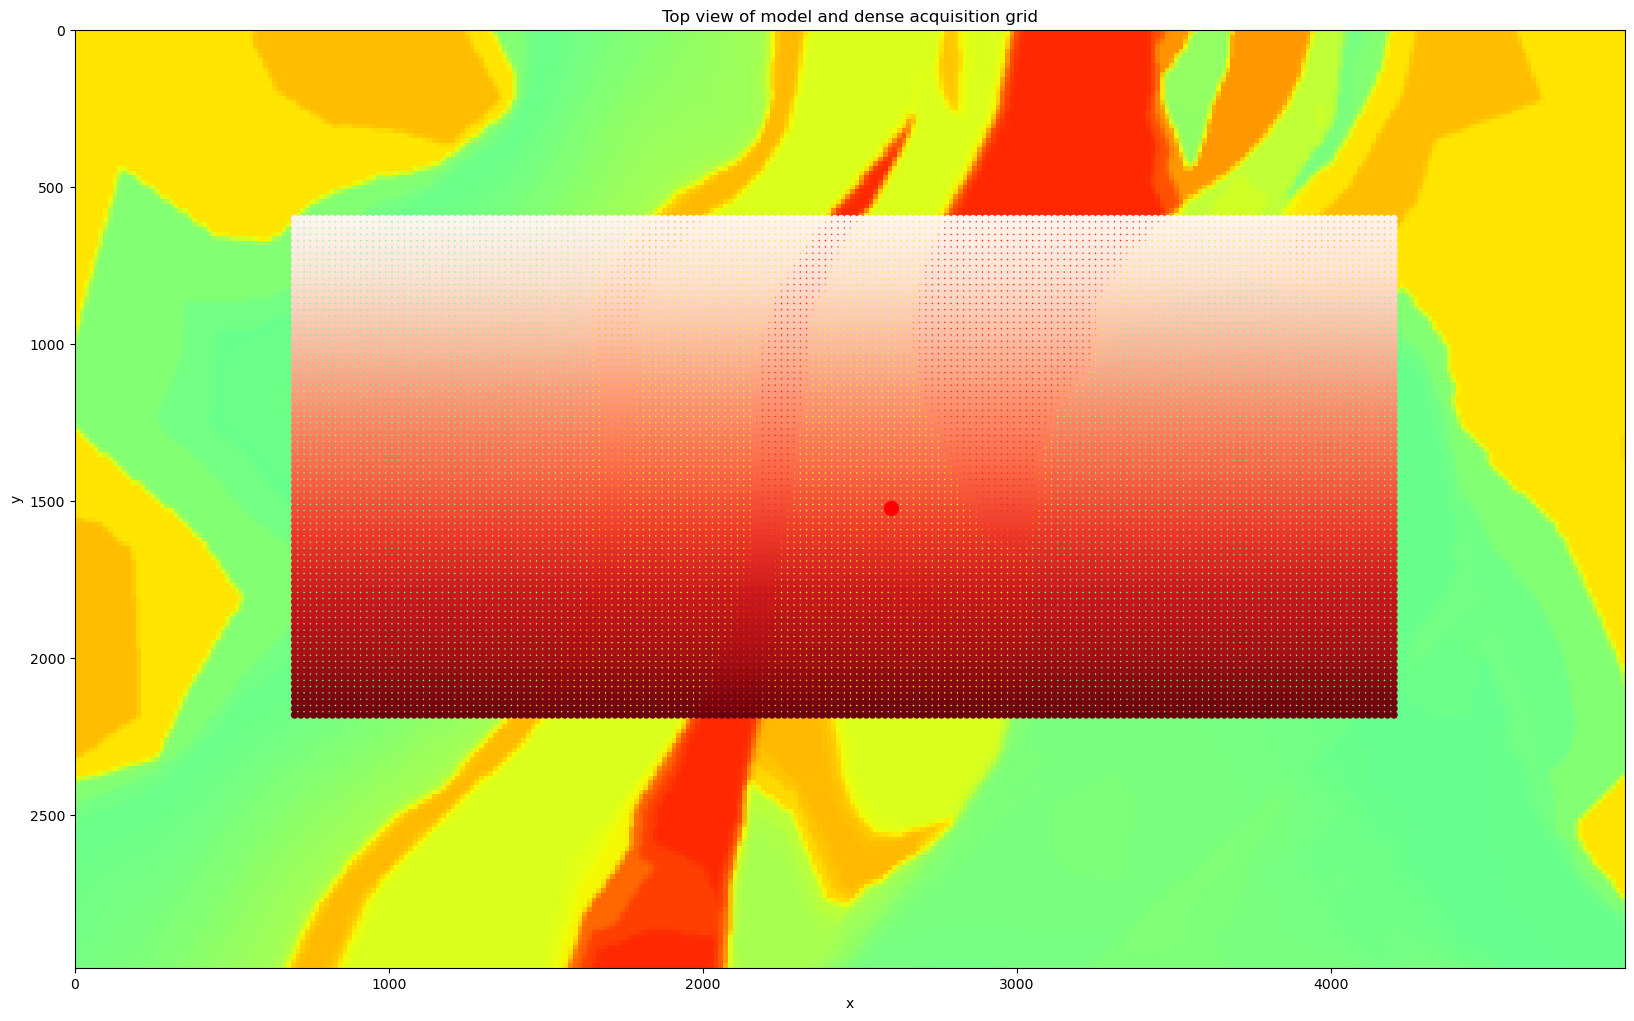

In [4]:
# Model
file = '../../data/Overthrust/overthrust_small.bin'
y, x, z = np.arange(ny)*15., np.arange(nx)*15., np.arange(nz)*15.

traces = np.fromfile(file, dtype='f')
vp = traces.reshape(ny, nx, nz).astype(np.float32) # y,x,z arrangment

# Acquisition
srcx = np.arange(300,x[-1]-300, 20)
srcy = np.arange(300,y[-1]-300, 20)

SRCY, SRCX = np.meshgrid(srcy, srcx, indexing='ij')
SRCX, SRCY = SRCX.ravel(), SRCY.ravel()

recx = np.arange(700,x[-1]-700, 20)[:nrx]
recy = np.arange(600,y[-1]-600, 20)[:nry]

RECY, RECX = np.meshgrid(recy, recx, indexing='ij')
RECX, RECY = RECX.ravel(), RECY.ravel()

plt.figure(figsize=(20, 14))
plt.imshow(vp[:, :, 100], cmap='jet', clim=[1000, 3500], extent=(x[0], x[-1], y[-1], y[0]))
plt.scatter(RECX, RECY, c=np.arange(len(RECX)), s=20, cmap='Reds')
plt.scatter(SRCX[isrc], SRCY[isrc], c='r', s=100)
plt.xlabel('x'), plt.ylabel('y')    
plt.title('Top view of model and dense acquisition grid');

## Define subsampling operator

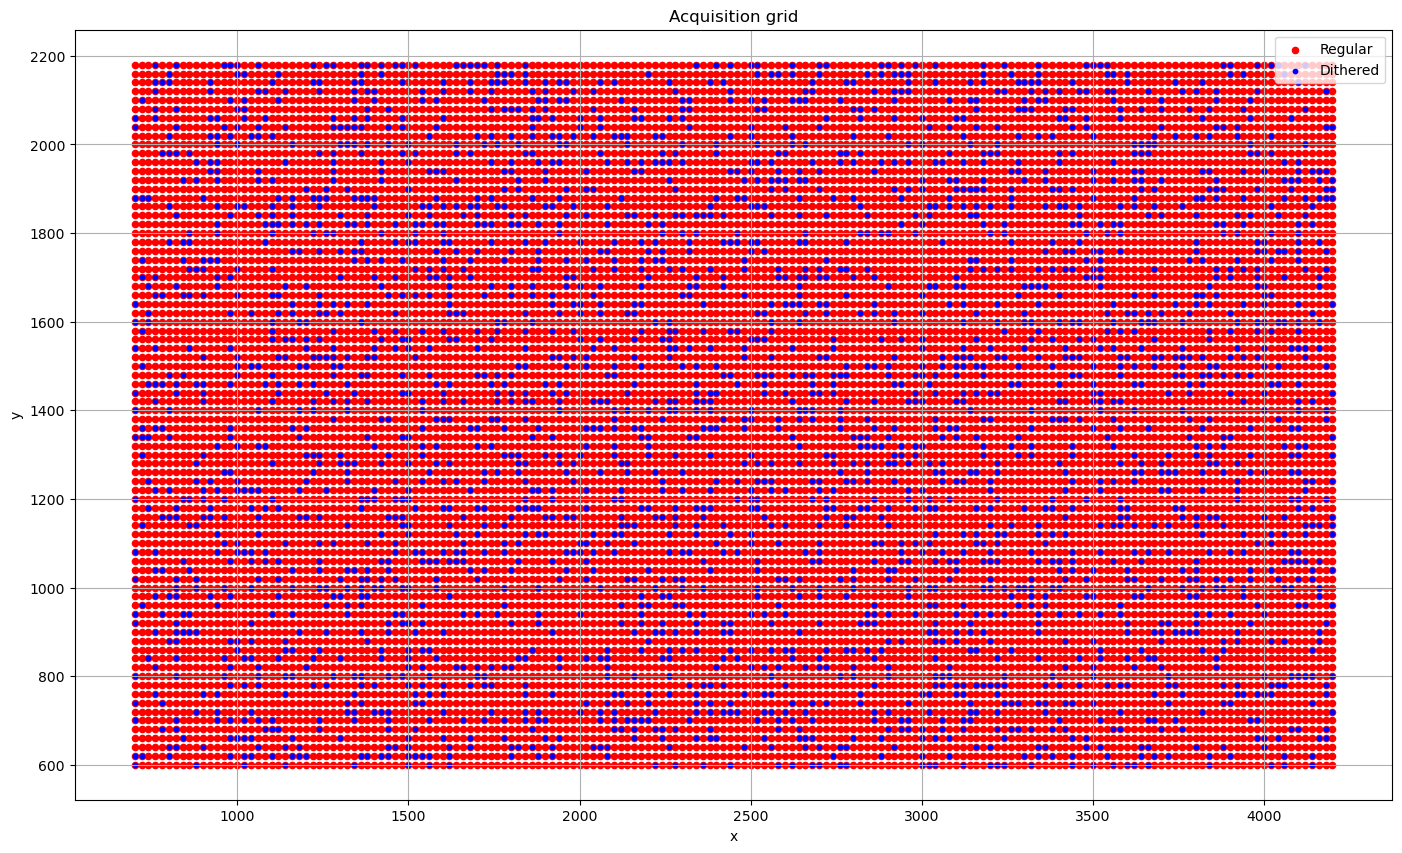

In [5]:
# subsampling locations
if perc_subsampling < 1:
    iava, iavarec = irregular2(ns, nr, nt, perc_sub=perc_subsampling, seed=10)

    plt.figure(figsize=(17, 10))
    plt.scatter(RECX, RECY, c='r', s=20, label='Regular')
    plt.scatter(RECX[iavarec], RECY[iavarec], c='b', s=10, label='Dithered')
    plt.grid(which='both')
    plt.xlabel('x'), plt.ylabel('y')
    plt.title('Acquisition grid')
    plt.legend()
else:
    iava, iava2d, iava2d_reg, dither = dithered_irregular2(ns, nr, nt, factor_sub=perc_subsampling, seed=10)
    print(f'Percentage subsampling {len(iava2d) / (nr*ns)}')

    plt.figure(figsize=(17, 10))
    plt.scatter(RECX, RECY, c='r', s=20, label='Regular')
    plt.scatter(RECX[iava2d_reg], RECY[iava2d_reg], c='g', s=10, label='Subsampled')
    plt.scatter(RECX[iava2d], RECY[iava2d], c='b', s=10, label='Dithered')
    plt.grid(which='both')
    plt.xlabel('x'), plt.ylabel('y')    
    plt.title('Acquisition grid')
    plt.legend()

# Create restriction operator
Rop = Restriction(dims=ns*nr*nt, iava=iava, dtype='float64')
datamasked = Rop.H*Rop*data.ravel()
mask = Rop.H*Rop*np.ones_like(data).ravel()
datamasked = datamasked.reshape(ns, nr, nt)
mask = mask.reshape(ns, nr, nt)

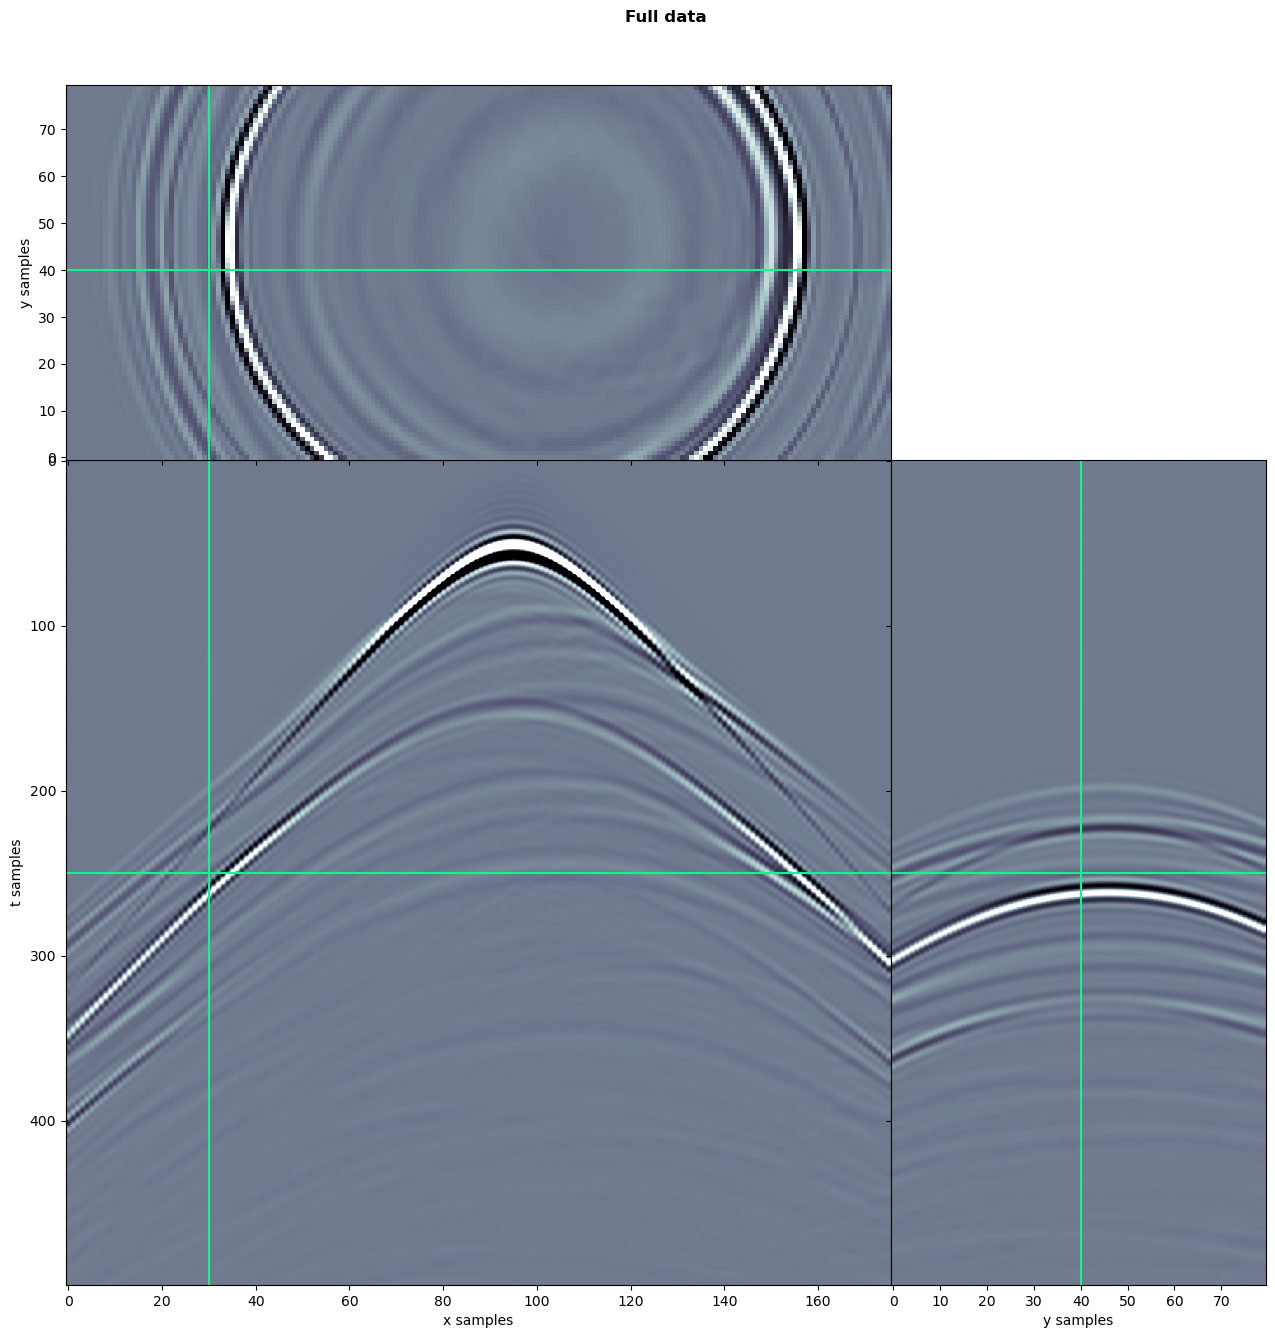

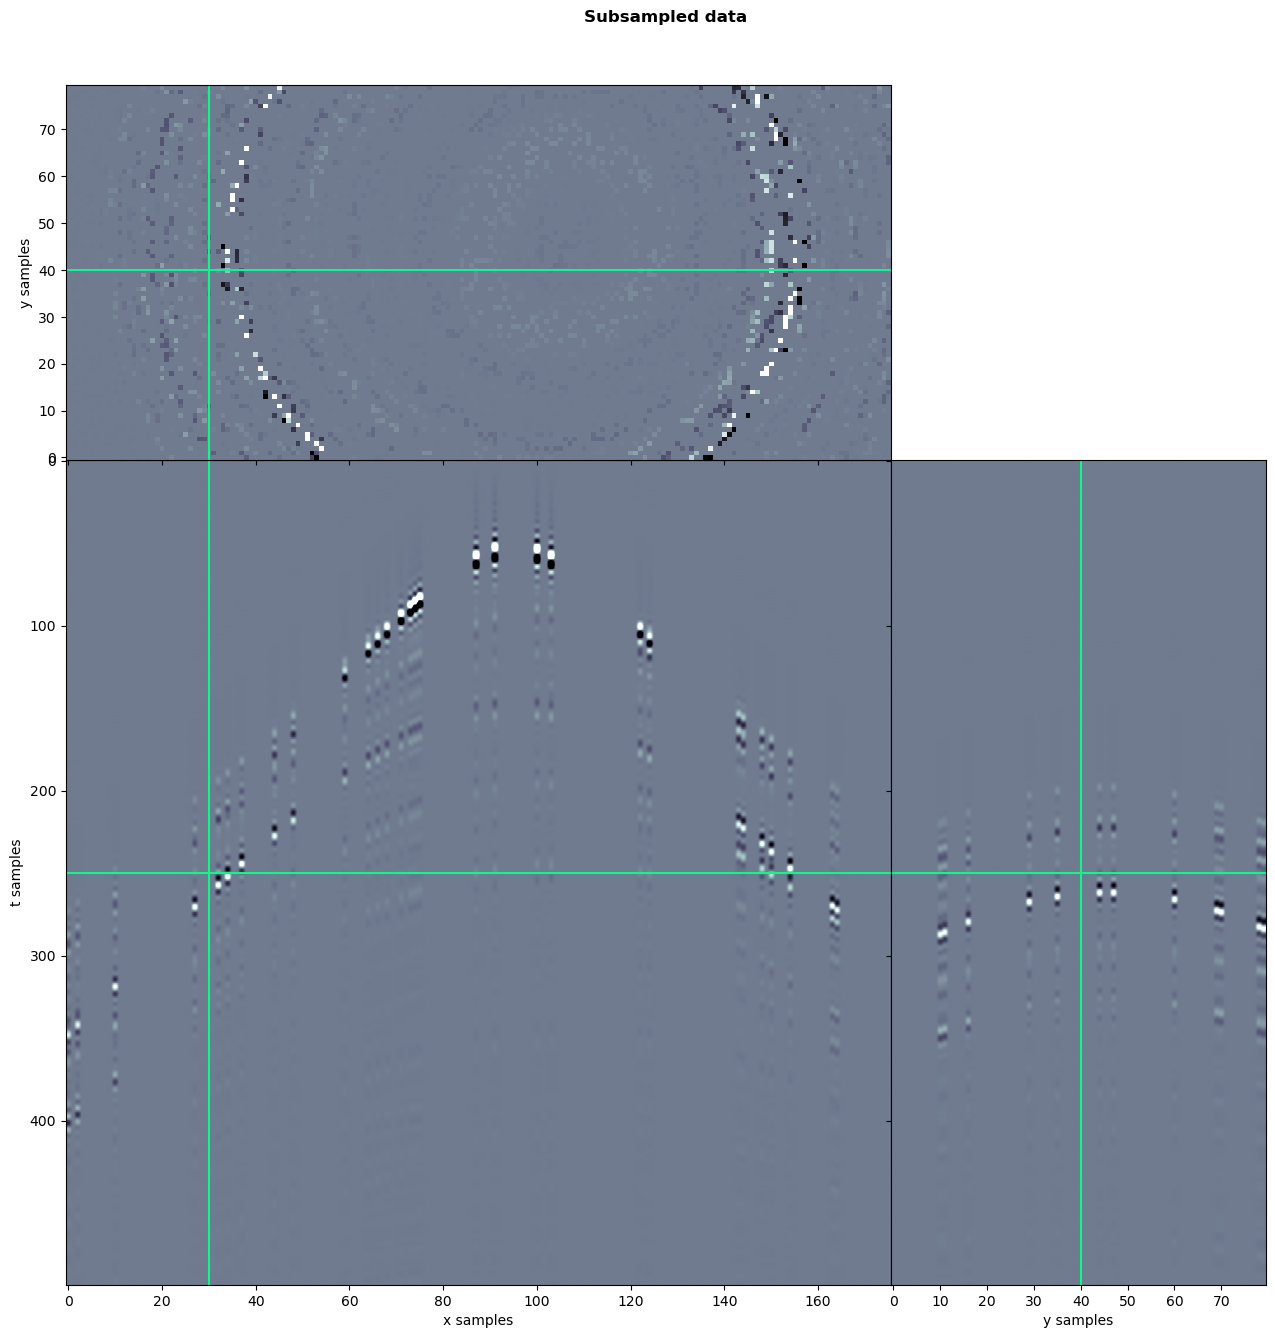

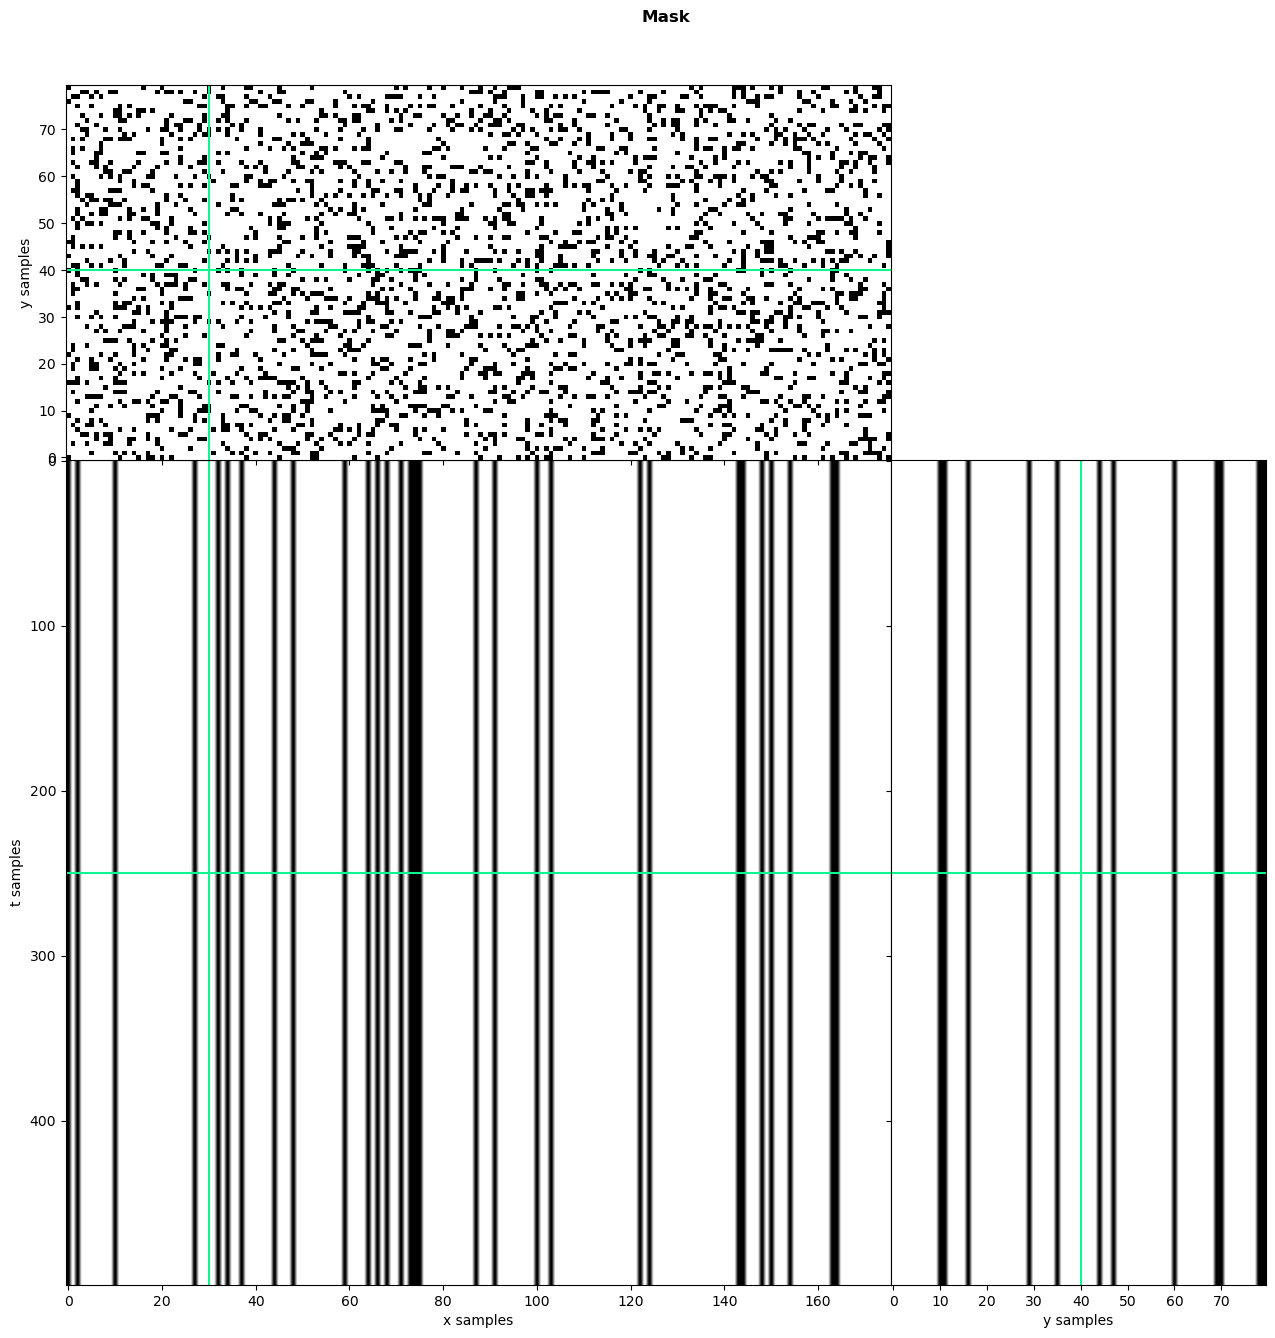

In [6]:
explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Full data')
explode_volume(datamasked.transpose(2, 0, 1),x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Subsampled data')
explode_volume(mask.transpose(2, 0, 1), x=30, cmap='gray_r', clipval=(0, 1), figsize=(15, 15), title='Mask');

## Pre-processing

### Create direct arrival mask

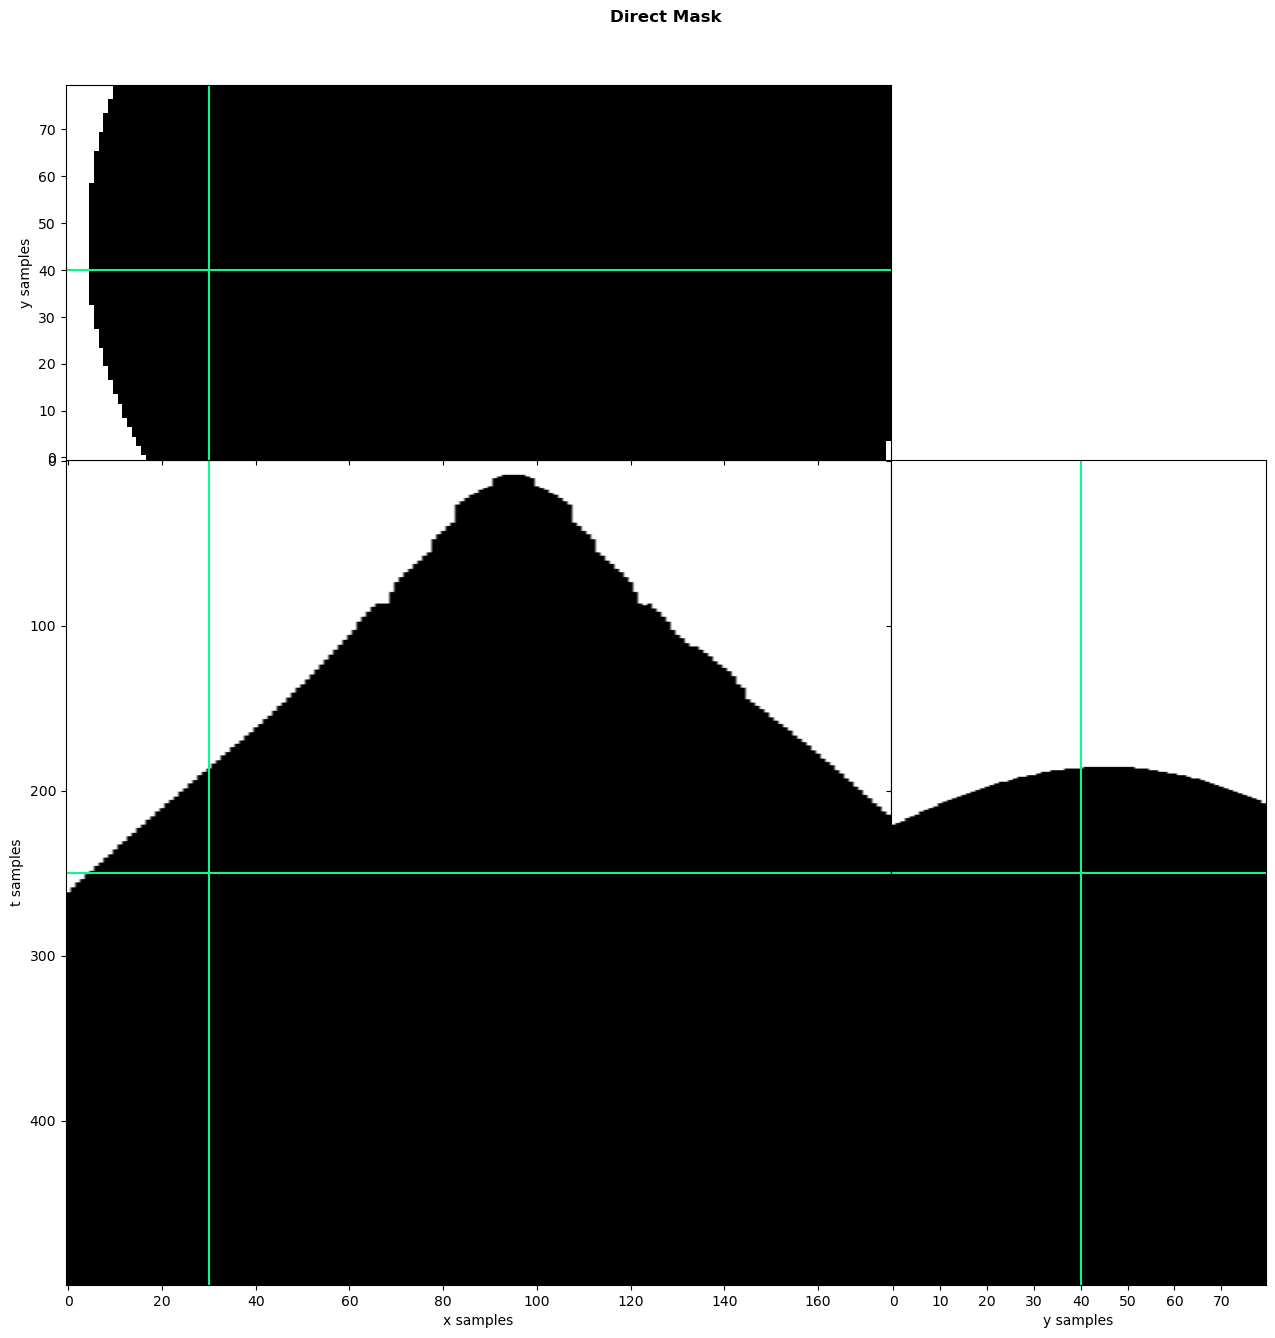

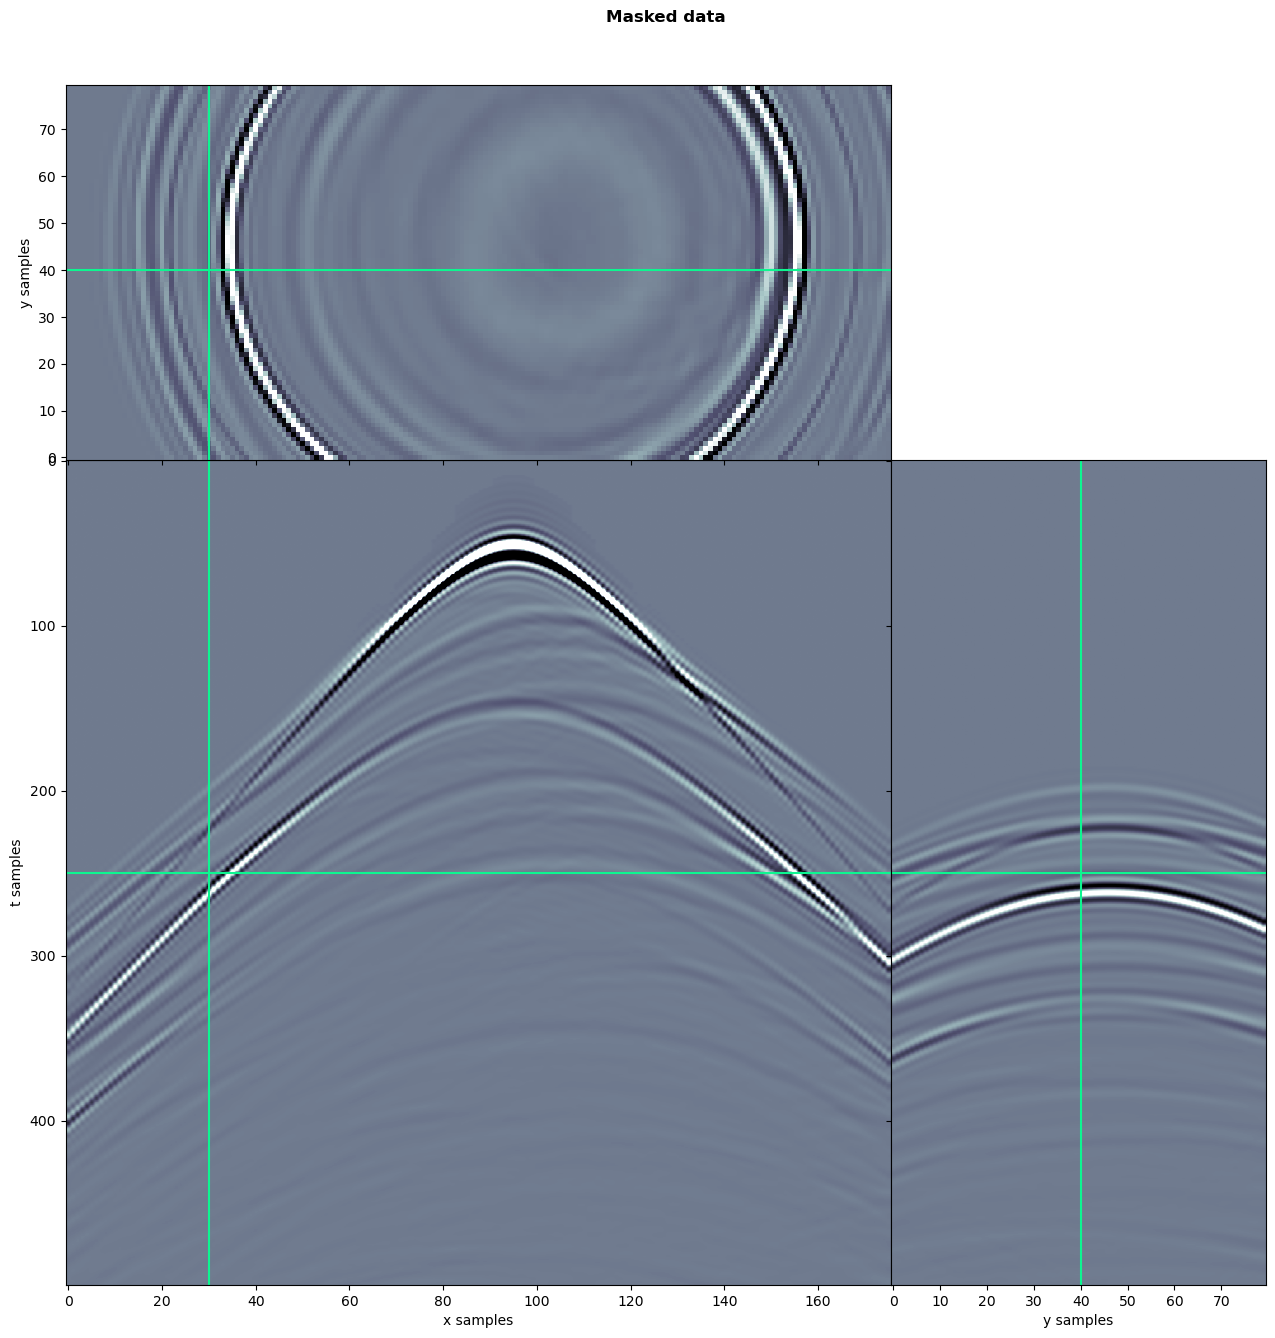

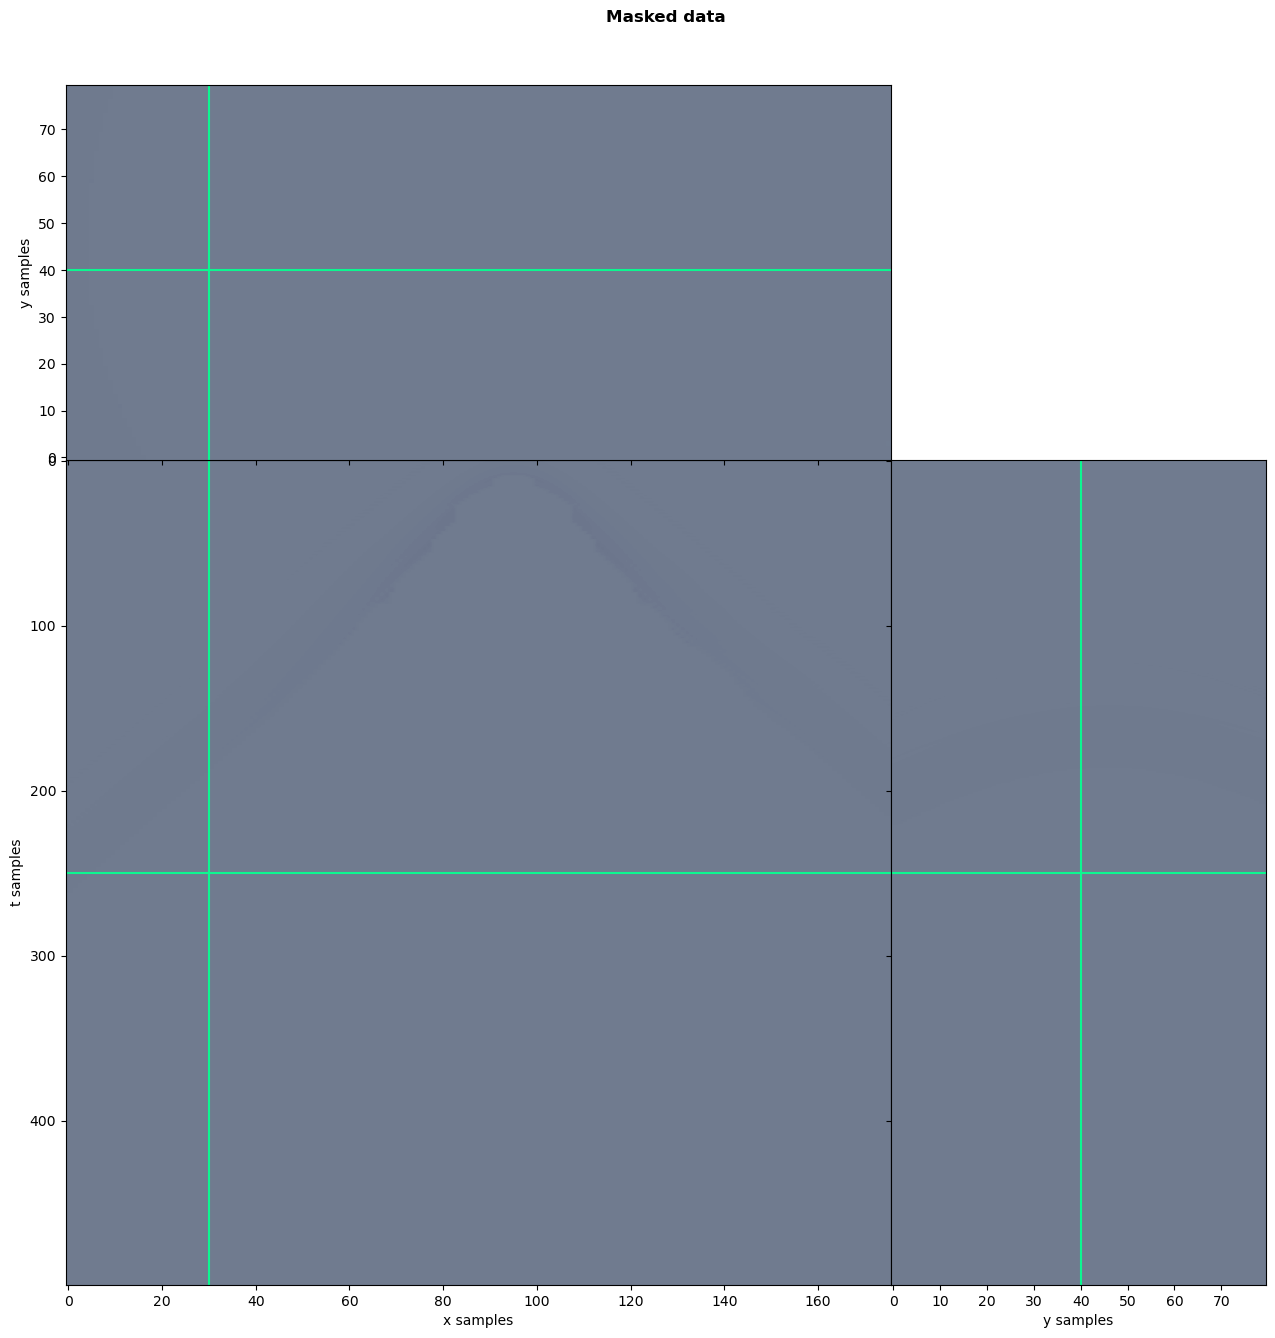

In [7]:
direct_mask = np.ones_like(data)
thresh = 0.01 * np.max(np.abs(data))
for iy in range(ns):
    for ix in range(nr):
        direct_mask[iy, ix, :max(0, np.where(np.abs(data[iy, ix]) > thresh)[0][0]-10)] = 0.

explode_volume(direct_mask.transpose(2, 0, 1), x=30, cmap='gray_r', clipval=(0, 1), figsize=(15, 15), title='Direct Mask')    
explode_volume((direct_mask*data).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Masked data')
explode_volume(((1-direct_mask)*data).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Masked data');

### Divide data in patches

 468], end:[ 32  58  84 110 136 162 188 214 240 266 292 318 344 370 396 422 448 474
 500]
 576], end:[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608]


(<Figure size 1500x1500 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

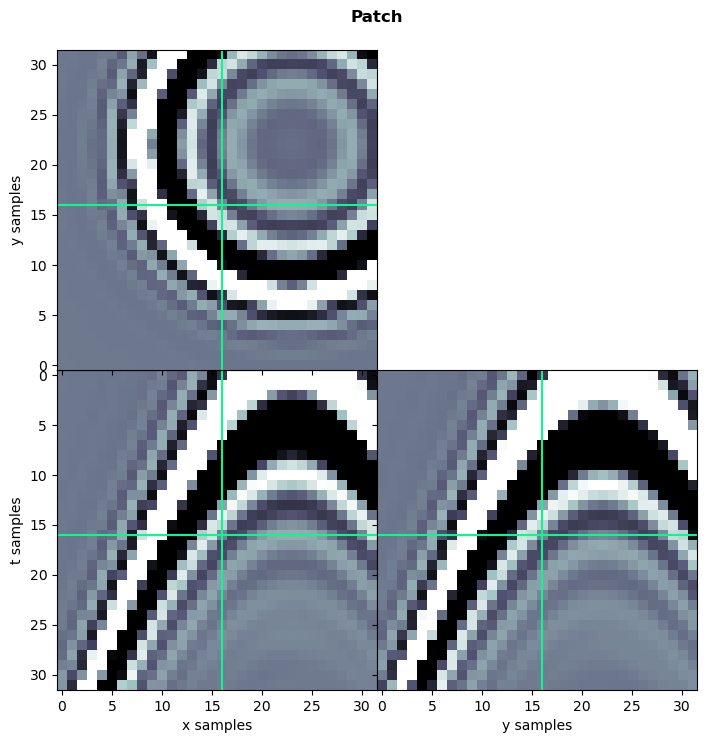

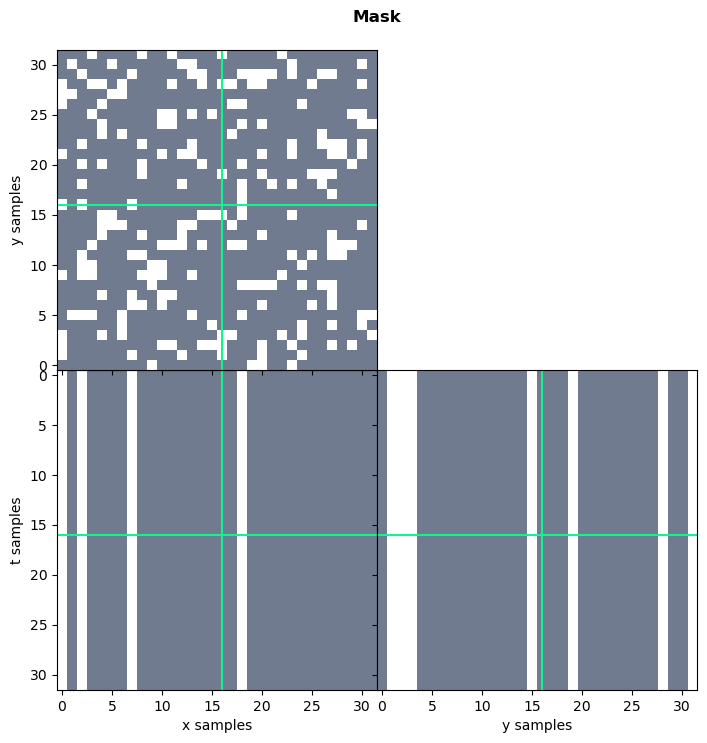

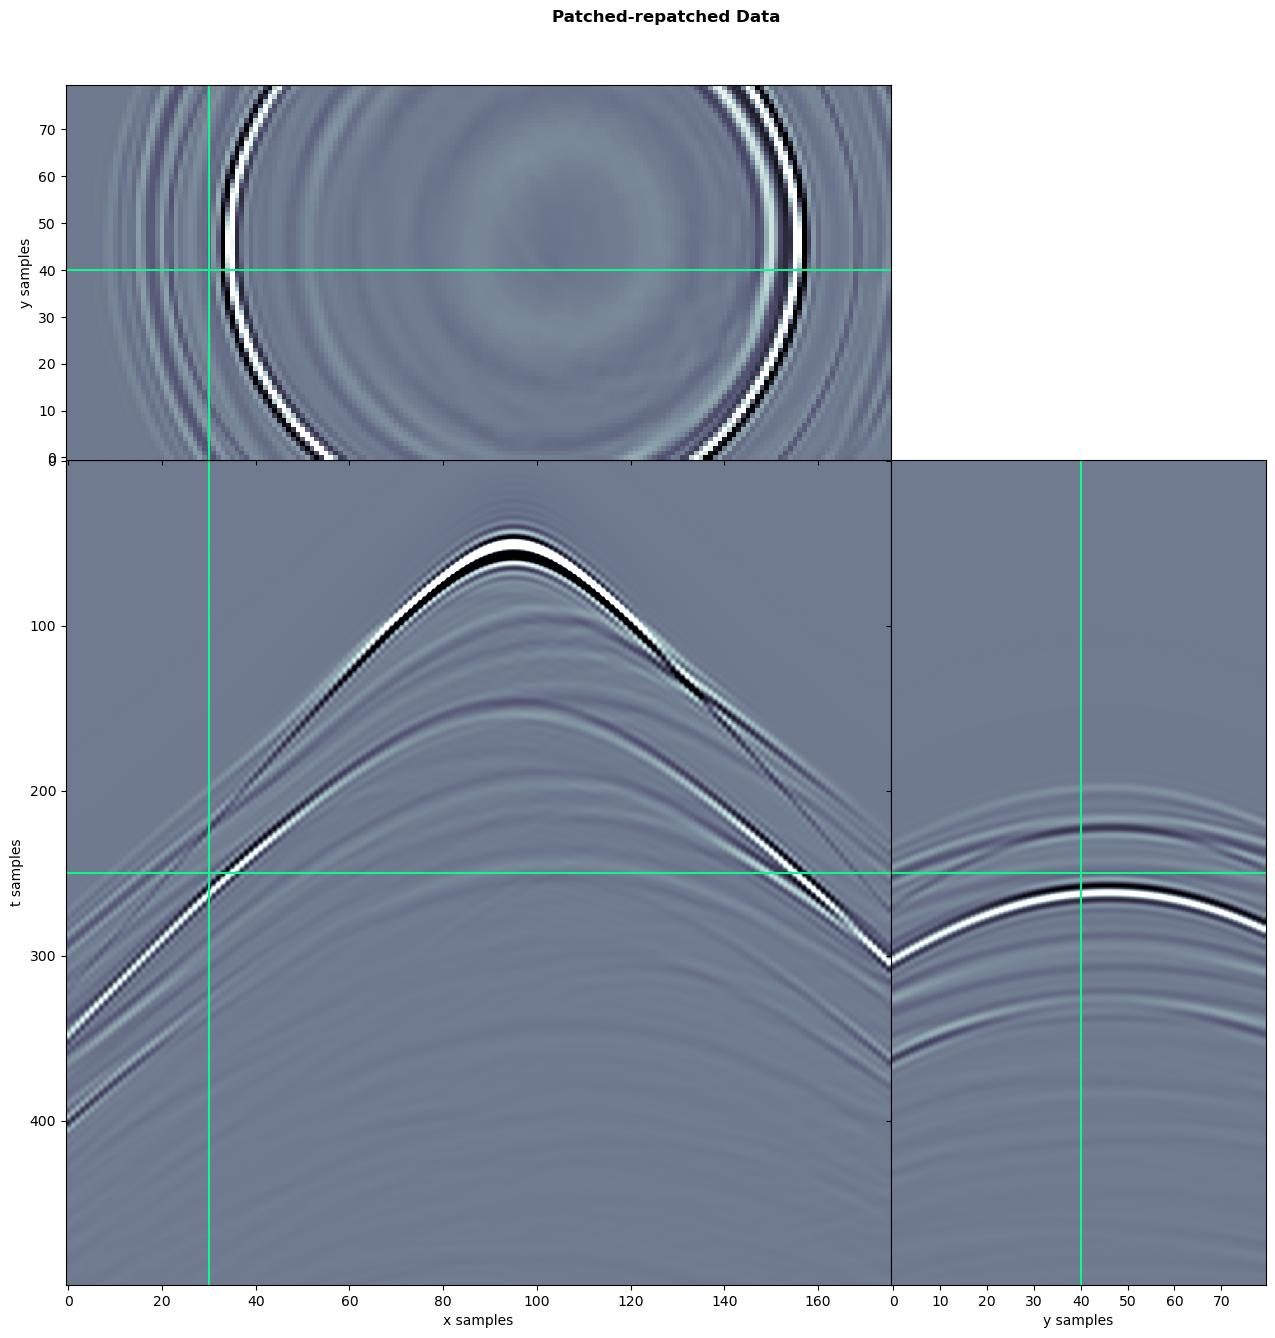

In [8]:
dimsd = data.shape
nwins, dims, mwins_inends, dwins_inends = patch3d_design(dimsd, nwin, nover, nwin)

Op = Identity(nwin[0]*nwin[1]*nwin[2], nwin[0]*nwin[1]*nwin[2])
Sop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin,
              tapertype=None)
Srecop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin,
                 tapertype='cosine')
patches = Sop.H * data
patchesmasked = Sop.H * datamasked
patchesmask = Sop.H * mask
databench = Srecop * patches

mask_patches = Sop.H * mask

explode_volume(patches[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2,0.2), figsize=(8, 8), 
               title='Patch')
explode_volume(mask_patches[iypatch, ixpatch, itpatch].transpose(2, 1, 0), clipval=(-0.2,0.2), figsize=(8, 8), 
               title='Mask')
explode_volume(databench.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Patched-repatched Data')

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='f(Hz) [s]'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

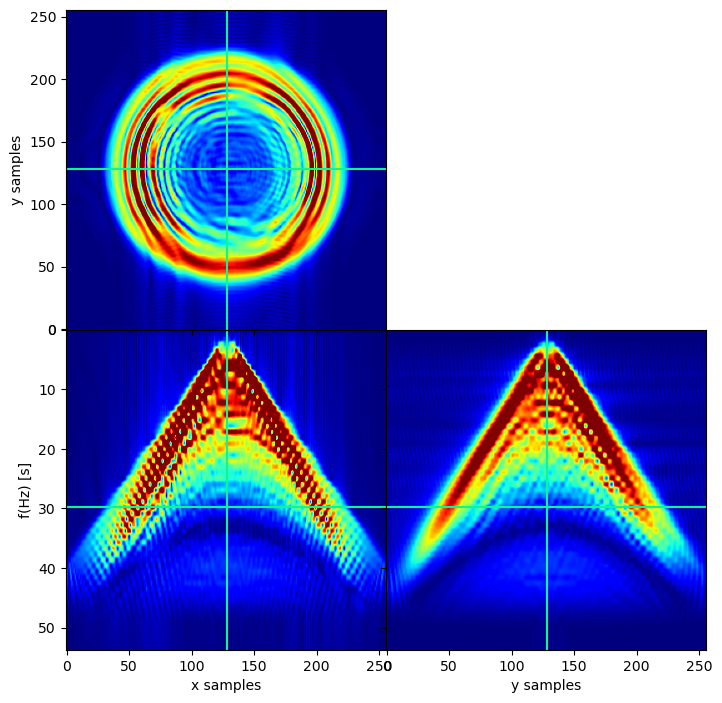

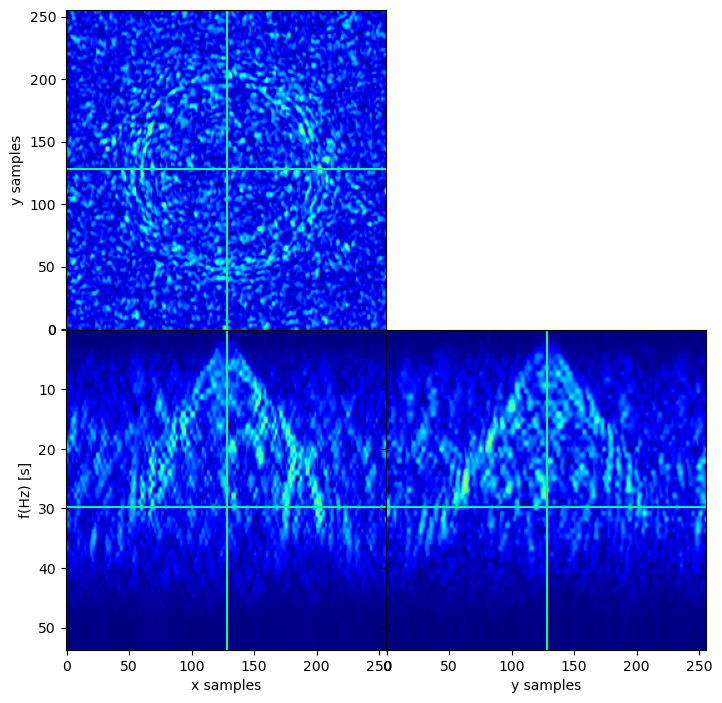

In [9]:
nfft=2**8

FFTop = FFTND(dims=[ns, nr, nt], nffts=[nfft, nfft, nfft], sampling=[dx, dx, dt], real=True)

datafk = FFTop @ data
datamaskedfk = FFTop @ datamasked

explode_volume(np.fft.fftshift(np.abs(datafk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

explode_volume(np.fft.fftshift(np.abs(datamaskedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

### Shift data

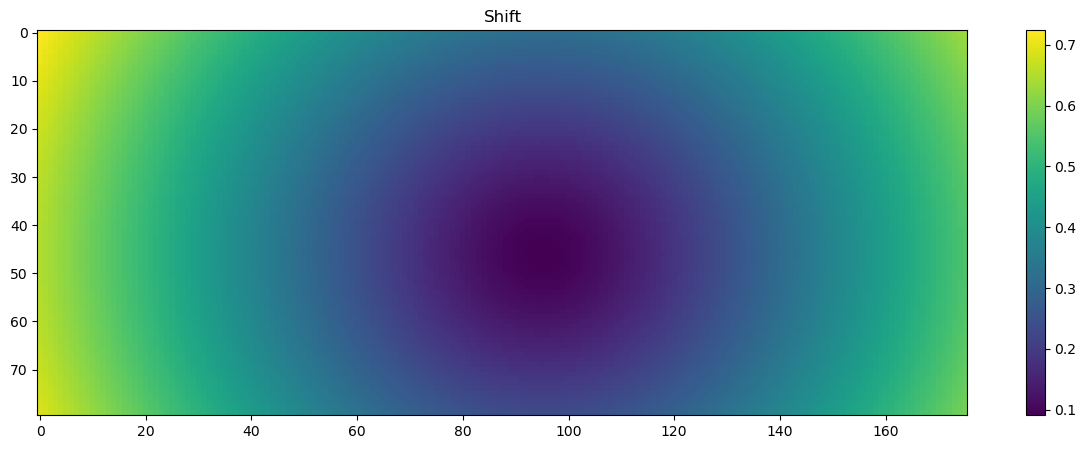

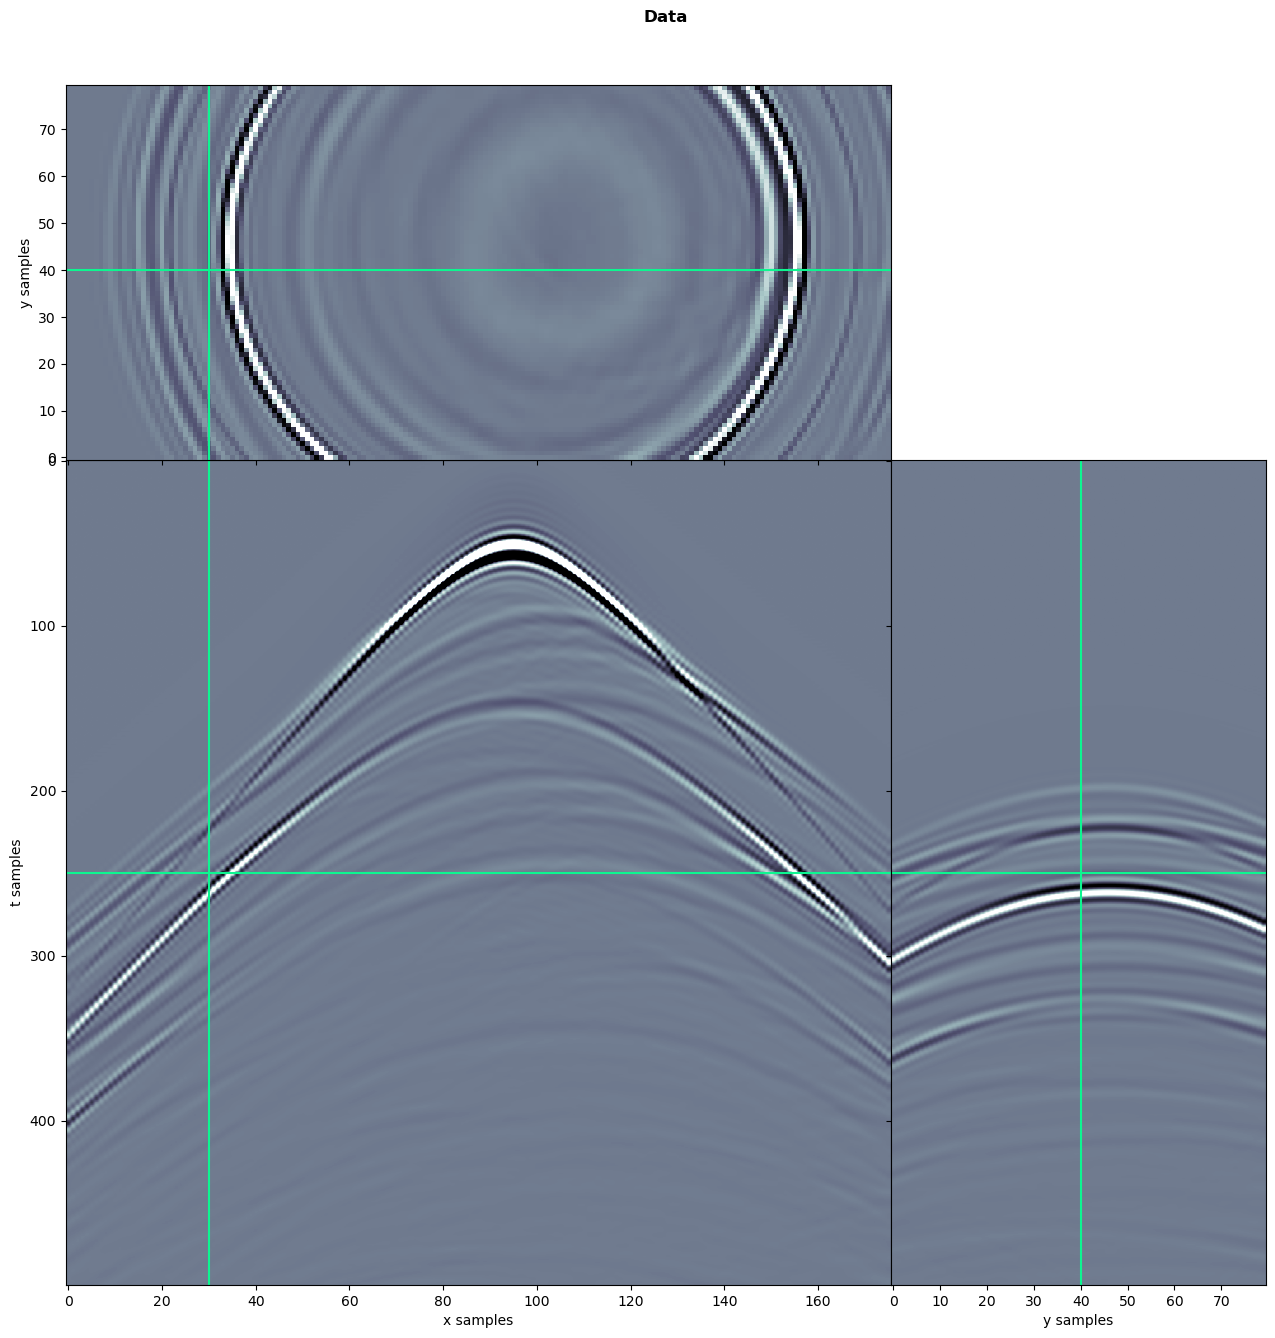

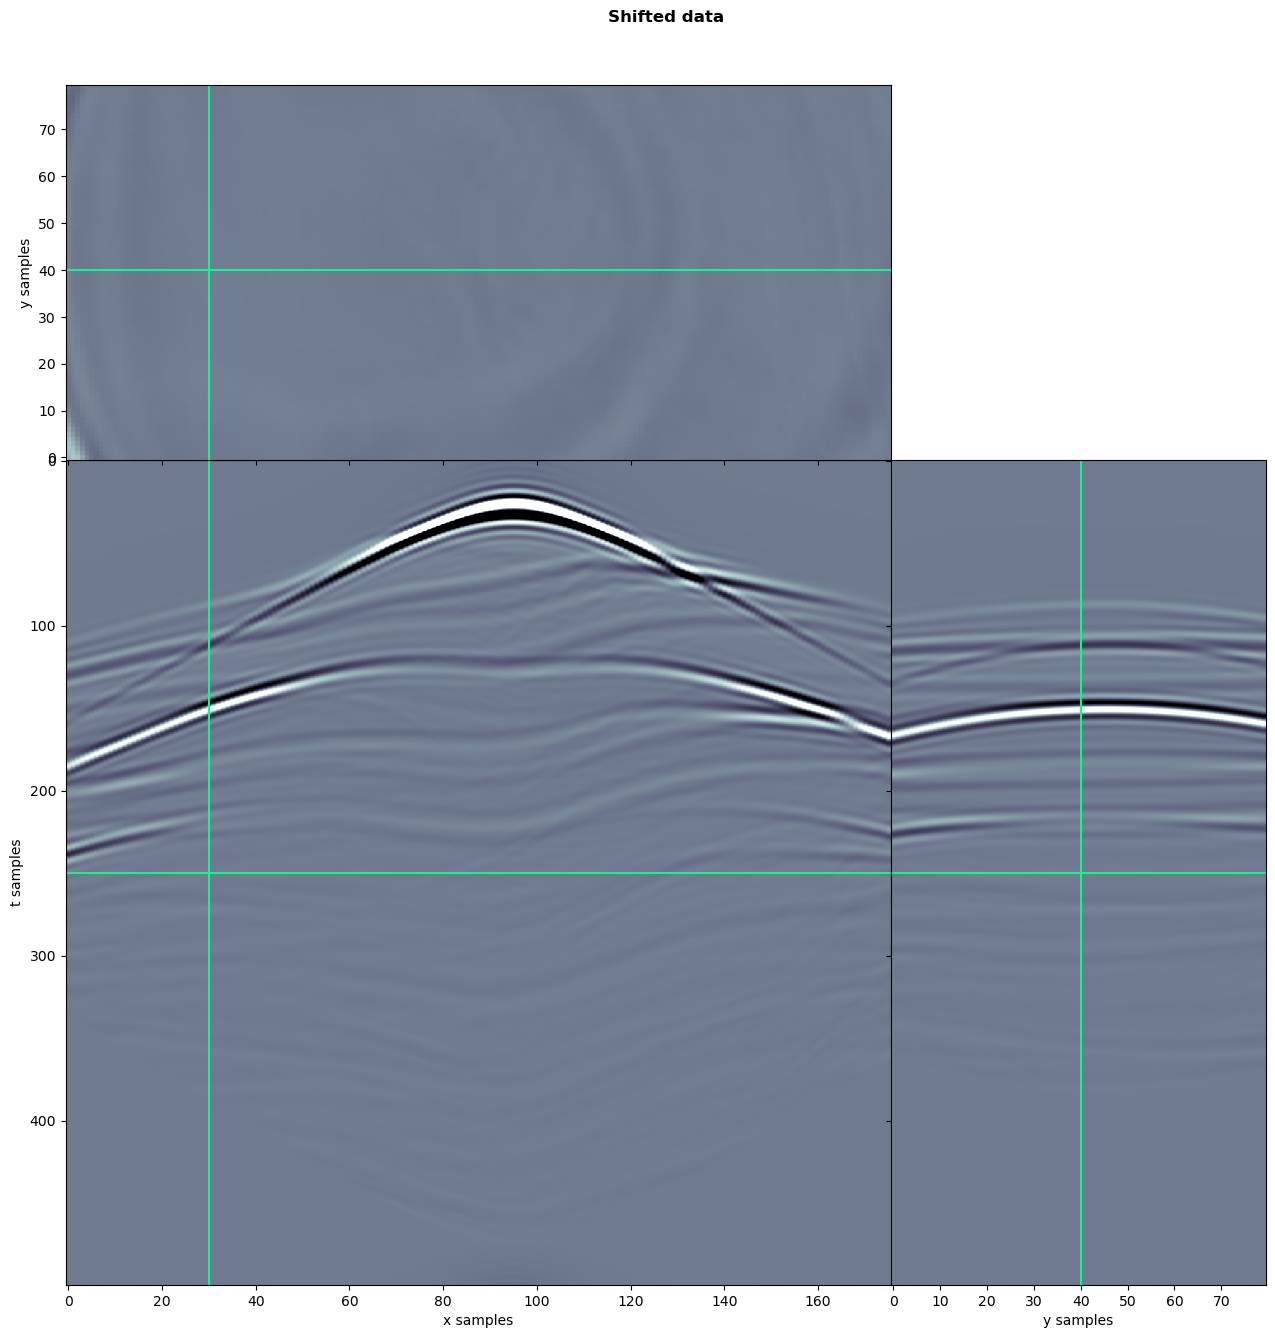

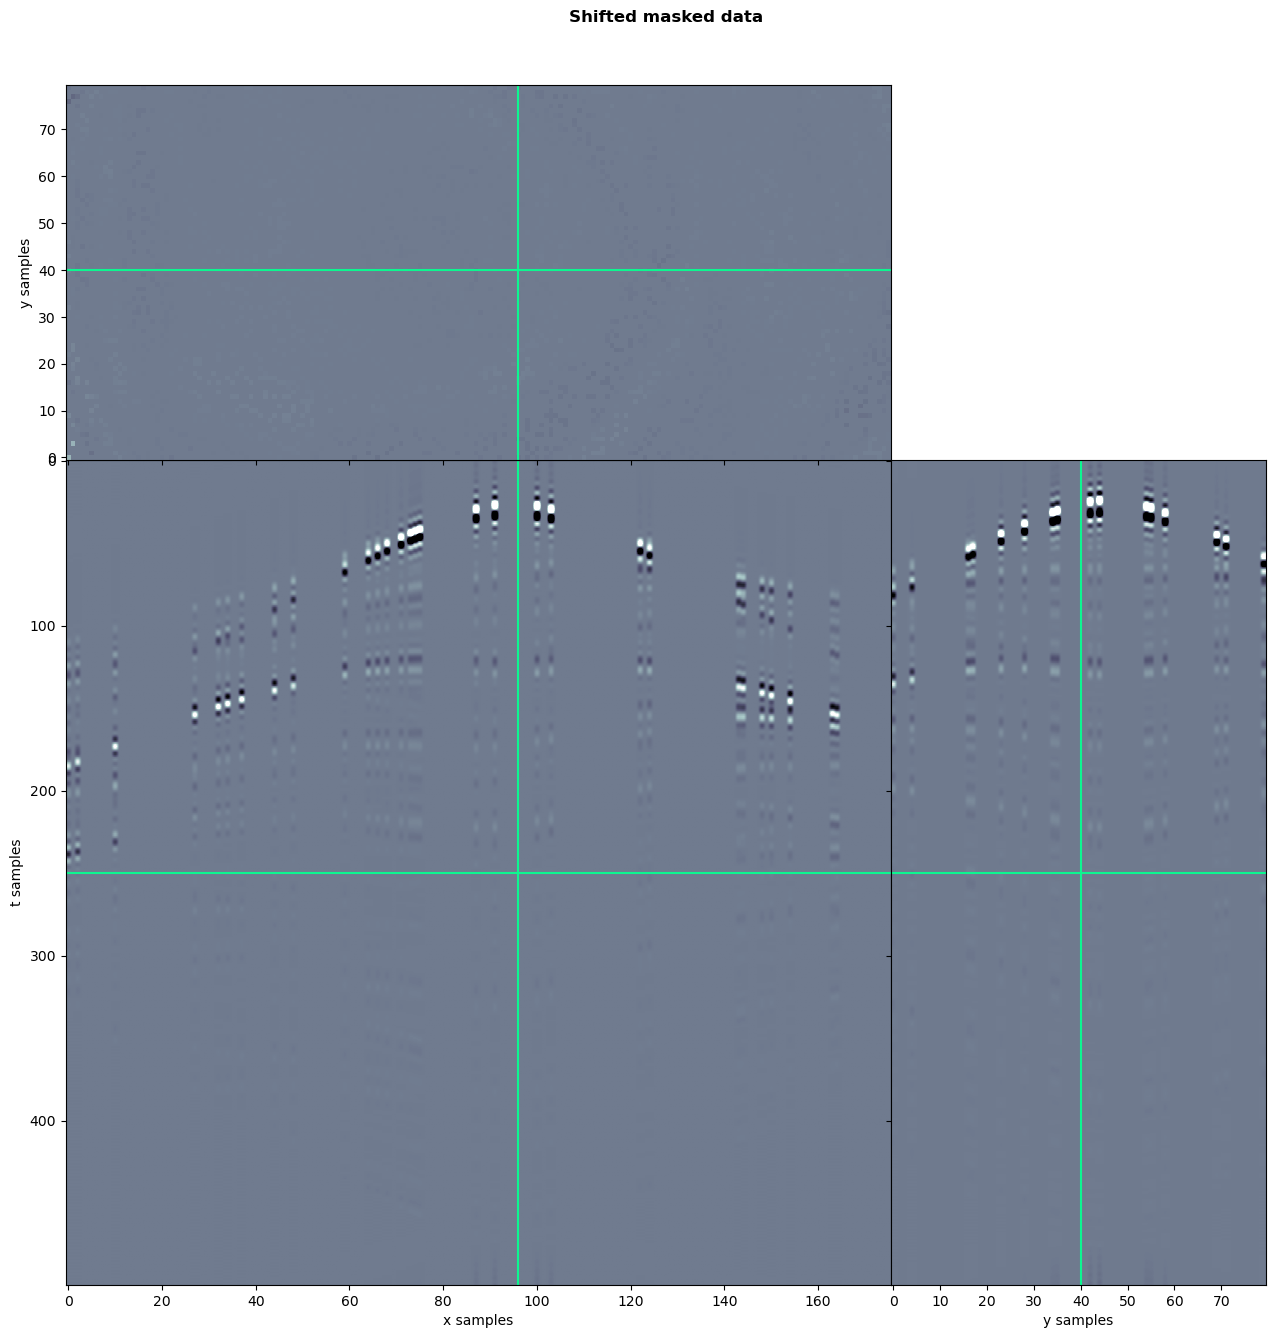

In [10]:
v = 4000
shift = np.power((300-10)**2 +
                (RECX.reshape(nry, nrx)-SRCX[isrc])**2 + 
                (RECY.reshape(nry, nrx)-SRCY[isrc])**2, 0.52) / v

plt.figure(figsize=(15, 5))
plt.imshow(shift)
plt.axis('tight')
plt.colorbar()
plt.title('Shift')

Shiftop = Shift((nrx, nry, nt), shift=-shift.T, sampling=dt, axis=2)
datashifted = np.real(Shiftop * data)
datareshifted = np.real(Shiftop.H * datashifted)
datashiftedmasked = Rop.H*Rop*datashifted.ravel()
datashiftedmasked = datashiftedmasked.reshape(ns, nr, nt)
direct_maskshifted = np.real(Shiftop * direct_mask)

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Data')
explode_volume(datashifted.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title='Shifted data')
explode_volume(datashiftedmasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(15, 15), title='Shifted masked data');

In [11]:
# Shift data and make patches ready for interpolation
patchesshifted = Sop.H * datashifted
patchesshiftedmasked = Sop.H * datashiftedmasked
direct_masksshifted = Sop.H * direct_maskshifted

patchnorms = np.sqrt(np.sum(patchesshifted**2, axis=(-3, -2, -1)))

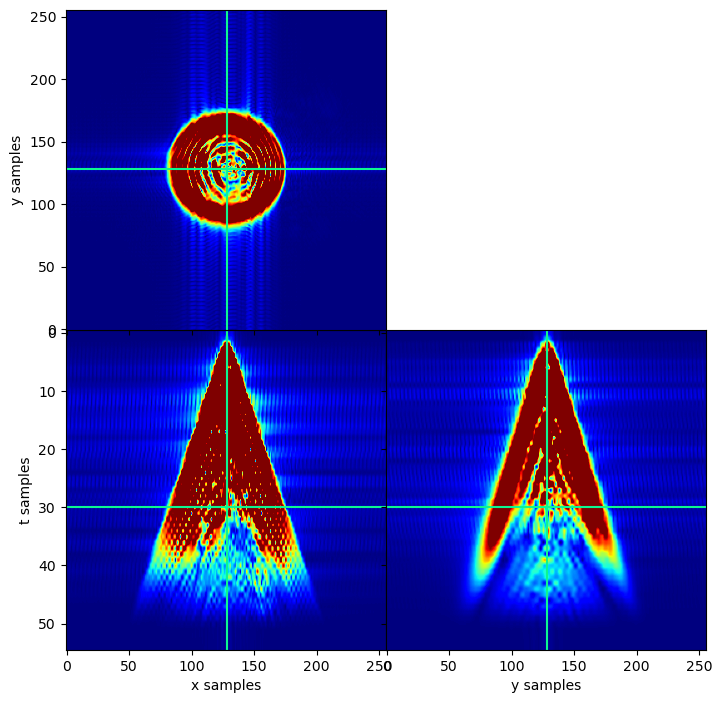

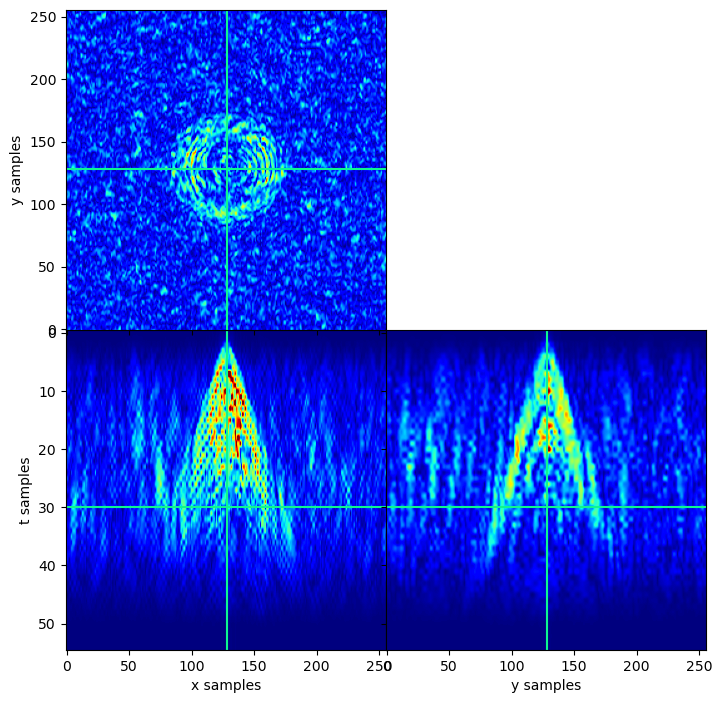

In [12]:
# FK spectra
datashiftedfk = FFTop @ datashifted
datashiftedmaskedfk = FFTop @ datashiftedmasked

explode_volume(np.fft.fftshift(np.abs(datashiftedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

explode_volume(np.fft.fftshift(np.abs(datashiftedmaskedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               cmap='jet', figsize=(8, 8), clipval=(0,0.2));

In [13]:
# Sava subsampled data
np.savez(f'../../experiments/Overthrust/Rec_fullirreg{perc_subsampling}_data.npz', 
         data=data,
         direct_mask=direct_mask,
         mask=mask,
         datamasked=datamasked,
         patchnorms=patchnorms)

## Run experiments

In [14]:
datarec_shiftedback = {}
error_shifted = {}
snr_shifted = {}

In [ ]:
for affine, identityop, norm, thresh, alg in zip(affines, identityops, norms, threshs, algs):
    
    normlabel = norm if isinstance(norm, str) else str(norm).split('.')[-1][:-2] 
    label = ('Affine_' if affine else 'EuclBall_') + 'Idop' + str(identityop) + '_'+ normlabel + \
    '_Th' + str(thresh) + '_' + str(alg).split()[1] + '_niter' + str(niter)
    savefile = f'../../experiments/Overthrust/Rec_fullirreg{perc_subsampling}_{label}.npz'
    
    if skipdone and os.path.exists(savefile):
        print(f'Skipping {label} (already available)')
    else:
        print(f'Working with {label}')

        patchesshiftedinterp = np.zeros_like(patches)
        patchesshiftedinterp_hist = np.zeros((int(niter // jsrnsave), *patches.shape))
        error_shifted[label] = np.zeros((patches.shape[0],patches.shape[1],patches.shape[2], niter))
        vb=True
        for iy in range(nwins[0]):
            print(f'Working with slice {iy}/{nwins[0]}')
            for ix in range(nwins[1]):
                for it in range(nwins[2]):
                    if np.sum(np.abs(patchesshiftedmasked[iy, ix, it])!=0) > 0.02*nwin[0]*nwin[1]*nwin[2]:
                        if verb: print(f'Working with {iy}/{ix}/{it}')
                        if alg == pocs_interpolate:
                            # POCS
                            patchesshiftedinterp[iy, ix, it], error_shifted[label][iy, ix, it] = \
                            alg(patchesshiftedmasked[iy, ix, it], 
                                mask_patches[iy, ix, it], [dx, dx, dt],
                                nfft, thresh, threshkind=norm, niter=niter, 
                                xtrue=patchesshifted[iy, ix, it], masktrue=direct_masksshifted[iy, ix, it],
                                history=False, backend="cupy", verb=vb)
                        else:
                            # HQS / PD /ADMM
                            patchesshiftedinterp[iy, ix, it], error_shifted[label][iy, ix, it], patch_hist = \
                                alg(patchesshiftedmasked[iy, ix, it], 
                                    mask_patches[iy, ix, it], [dx, dx, dt],
                                    nfft, thresh, niter=niter, 
                                    xtrue=patchesshifted[iy, ix, it], #masktrue=direct_masksshifted[iy, ix, it],
                                    affine=affine, identityop=identityop, norm=norm,
                                    history=jsrnsave, backend="cupy", verb=vb)
                            # save patches at selected iterations
                            for iiter in range(int(niter // jsrnsave)):
                                patchesshiftedinterp_hist[iiter, iy, ix, it] = patch_hist[iiter].reshape(nwin)
                        vb = False
                    else:
                        if verb: print(f'Skipping {iy}/{ix}/{it}')       

        # Reconstruction
        datarec_shifted = Srecop * patchesshiftedinterp
        datarec_shifted[np.isnan(datarec_shifted)] = 0.
        datarec_shiftedback[label] = direct_mask*np.real(Shiftop.H * datarec_shifted)

        explode_volume((datarec_shiftedback[label]).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(15, 15), title=label)
        explode_volume((datarec_shiftedback[label]).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
                       clipval=(-0.2,0.2), figsize=(15, 15), title='Error')
        
        # SNR progression
        snr_shifted[label] = []
        for iiter in range(int(niter // jsrnsave)):
            datarec_pdshifted_iiter = Srecop * patchesshiftedinterp_hist[iiter]
            datarec_pdshifted_iiter[np.isnan(datarec_pdshifted_iiter)] = 0.
            datarec_pdshiftedback_iiter = direct_mask*np.real(Shiftop.H * datarec_pdshifted_iiter)
            snr_shifted[label].append(metrics(data, datarec_pdshiftedback_iiter, itmin=0)[1])
        snr_shifted[label].append(metrics(data, direct_mask*datarec_shiftedback[label], itmin=0)[1])
      
        # FK
        datarec_fk = FFTop @ datarec_shiftedback[label]
        explode_volume(np.fft.fftshift(np.abs(datarec_fk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
                   cmap='jet', figsize=(8, 8), clipval=(0,0.2))

        # Single patch plotting
        explode_volume(patchesshifted[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2, 0.2), 
                       figsize=(8, 8), title='Data')
        explode_volume(patchesshiftedmasked[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2, 0.2), 
                       figsize=(8, 8), title='Masked Data')
        explode_volume(patchesshiftedinterp[iypatch, ixpatch, itpatch].transpose(2, 0, 1), clipval=(-0.2, 0.2), 
                       figsize=(8, 8), title='Rec Data - POCS')

        # Error
        explode_volume(error_shifted[label][...,-1].transpose(2, 0, 1),
                       clipval=(0,1), figsize=(15, 15), title=f'Error {label}', cmap='jet') #, cbar=True)

        plt.figure(figsize=(15, 10))
        for iy in range(nwins[0]):
            for ix in range(nwins[1]):
                for it in range(nwins[2]):
                    plt.plot(error_shifted[label][iy,ix,it], 'k', lw=0.5)
        plt.plot(np.nanmean(error_shifted[label],axis=(0,1,2)), 'c', lw=4)
        
        _ = metrics(data, datarec_shiftedback[label], itmin=0, verb=True)
        print();

        np.savez(savefile, 
                 datarec=datarec_shiftedback[label],
                 error=error_shifted[label],
                 snr=snr_shifted[label])

Working with Affine_IdopTrue_L0_ThNone_hqs_interpolate_niter80
Working with slice 0/7
thesh=[0.13902469 0.13116886 0.12375693 0.11676383 0.11016588 0.10394077
 0.09806741 0.09252594 0.0872976  0.08236469 0.07771053 0.07331936
 0.06917632 0.06526739 0.06157935 0.0580997  0.05481667 0.05171916
 0.04879668 0.04603934 0.0434378  0.04098327 0.03866744 0.03648247
 0.03442096 0.03247595 0.03064084 0.02890942 0.02727584 0.02573457
 0.0242804  0.02290839 0.02161391 0.02039258 0.01924026 0.01815306
 0.01712729 0.01615948 0.01524636 0.01438484 0.013572   0.01280509
 0.01208151 0.01139883 0.01075472 0.010147   0.00957363 0.00903265
 0.00852225 0.00804068 0.00758633 0.00715765 0.00675319 0.00637159
 0.00601156 0.00567186 0.00535136 0.00504898 0.00476367 0.00449449
 0.00424053 0.00400091 0.00377483 0.00356153 0.00336027 0.0031704
 0.00299125 0.00282222 0.00266275 0.00251228 0.00237032 0.00223638
 0.00211001 0.00199078 0.00187829 0.00177215 0.00167202 0.00157754
 0.00148839 0.00140429]
HQS interpolat